# CBIOMES Global Model Output

This julia notebook uses either (1) the [MIT-CBIOMES opendap](http://engaging-opendap.mit.edu:8080/las/) (e.g. visit [this page](http://engaging-opendap.mit.edu:8080/las/UI.vm#panelHeaderHidden=false;differences=false;autoContour=false;xCATID=3C6AA795DF3E9F4E1208CEFE8341F298;xDSID=id-ab2a4e0c65;varid=MXLDEPTH-id-cdfa319965;imageSize=auto;over=xy;compute=Nonetoken;tlo=15-Jan-1992%2000:00;thi=15-Jan-1992%2000:00;catid=3C6AA795DF3E9F4E1208CEFE8341F298;dsid=id-ab2a4e0c65;varid=MXLDEPTH-id-cdfa319965;avarcount=0;xlo=-180;xhi=180;ylo=-90;yhi=90;operation_id=Plot_2D_XY_zoom;view=xy) or (2) the [Simons CMAP data base](https://cmap.readthedocs.io/en/latest/) (go to [this page](https://cmap.readthedocs.io/en/latest/catalog/datasets/Darwin_clim.html#darwin-clim)) to access Darwin model output from the [CBIOMES](https://cbiomes.org) project.


<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 200px;"/>

## Using Opendap

The `NCDatasets.jl` package readily supports lazy access to opendap data sets. The function below for example plots Iron concentration for a chosen depth level and month.

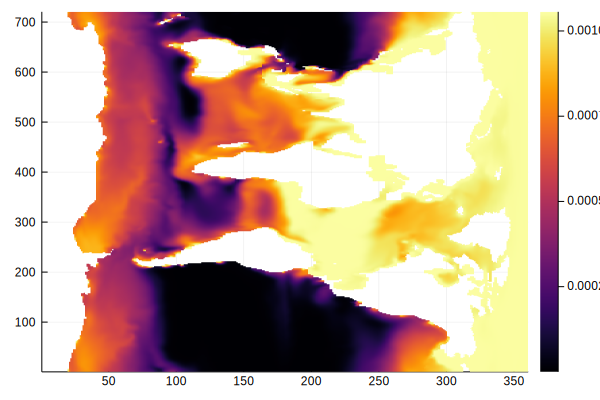

In [1]:
using NCDatasets, Plots

function test_opendapp(k,t)
    srv="http://engaging-opendap.mit.edu:8080/thredds/dodsC/las/"
    fil="id-2e0ea5ca2c/data_usr_local_tomcat_content_cbiomes_20200206_17_Nutrients_FeT.0001.nc.jnl"
    test=Dataset(srv*fil)
    tmp=test["FeT"][:,:,k,t]
    tmp[findall(tmp.<=-0.99e34)].=NaN
    return tmp
end

heatmap(test_opendapp(1,1))

### Using pycmap


_Pre-requisites:_

- 1. _install the [PyCmap](https://github.com/simonscmap/pycmap) python package and its dependencies using `pip`_
- 2. _compile [PyCall.jl](https://github.com/simonscmap/pycmap) using external python distribution that installed `PyCmap`_
- 3. _obtain your own API key from the [SimonsCMAP website](https://simonscmap.com) (free, just need email, takes `<30s`)_

In [2]:
if false
    run(`pip install pycmap`) #pycmap is used via PyCall later
    run(pipeline(`which python`,"whichpython.txt")) #external python path
    ENV["PYTHON"]=readline("whichpython.txt")
    import Pkg; Pkg.build("PyCall")
end

### Import _pycmap_ Into _julia_

[PyCmap](https://github.com/simonscmap/pycmap) is the `Python` API that we will use in `julia` (to query the `CMAP` data base) via the [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) package. 

_You may need to replace `your-own-API-key` (as outline below) with your own API key from the [SimonsCMAP website](https://simonscmap.com) and uncomment the command below._

In [3]:
using PyCall
PyCmap = pyimport("pycmap")
#cmap = PyCmap.API(token="your-own-API-key")
cmap = PyCmap.API()

PyObject <pycmap.cmap.API object at 0x7fe5402c3410>

### Get Data Catalog

_See [SimonsCMAP website](https://simonscmap.com) for more information. The commented `df.to_csv` call below creates `catalog.csv` and writes the data from `df` to this file._

In [4]:
df = cmap.get_catalog();
#df.to_csv("catalog.csv")

#### Download a regional Chlorophyll data set from the Darwin model

The `space_time` function returns the same data to memory as a python object that is easily saved to a `csv` file.

In [5]:
tables = ["tblDarwin_Nutrient"] # see catalog.csv  for the complete list of tables and variable names
variables = ["FeT"] # see catalog.csv  for the complete list of tables and variable names   
startDate = "1994-01-03"
endDate = "1994-01-03"
lat1, lat2 = 10, 70
lon1, lon2 = -180, -80
depth1, depth2 = 0, 10

df = cmap.space_time(tables[1], variables[1], startDate, endDate, 
    lat1, lat2, lon1, lon2, depth1, depth2)

pth="../samples/gradients/"
!isdir("$pth") ? mkdir("$pth") : nothing
df.to_csv("$pth"*"FeT.csv")

The data can then easily be read and manipulated as a Julia DataFrame.

In [6]:
using CSV, DataFrames
df = CSV.File("$pth"*"FeT.csv") |> DataFrame!

,Column1,time,lat,lon,depth,FeT
,Int64,Dates…,Float64,Float64,Int64,Float64⍰
1,0,1994-01-03T00:00:00,10.25,-179.75,5,3.5989e-7
2,1,1994-01-03T00:00:00,10.25,-179.25,5,3.58867e-7
3,2,1994-01-03T00:00:00,10.25,-178.75,5,3.54147e-7
4,3,1994-01-03T00:00:00,10.25,-178.25,5,3.50355e-7
5,4,1994-01-03T00:00:00,10.25,-177.75,5,3.48468e-7
6,5,1994-01-03T00:00:00,10.25,-177.25,5,3.48293e-7
7,6,1994-01-03T00:00:00,10.25,-176.75,5,3.48275e-7
8,7,1994-01-03T00:00:00,10.25,-176.25,5,3.52629e-7
9,8,1994-01-03T00:00:00,10.25,-175.75,5,3.70665e-7
